In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as func
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torch.utils.data import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader


In [2]:
import os
import shutil
import glob
import zipfile
import requests

In [3]:
import cv2
import math
import time
import random as rd
from PIL import Image
from tqdm import tqdm


In [4]:
Root_dir = '/content'
Data_dir = '/content/dataset'

#구글 드라이브
'''
Drive_url = "https://drive.google.com/uc"
Drive_param = {"export":"download","id":"1EL6Z2b-T39Wvpc2ZfQ87ffI7D9zkPsEd","confirm":"t"}
'''
Data_url = "https://drive.google.com/uc?export=download&id=1EL6Z2b-T39Wvpc2ZfQ87ffI7D9zkPsEd&confirm=t"

In [5]:
# 파일 다운로드
def file_download(url,f_name):
  with open(f_name,'wb') as file:
    response = requests.get(url)
    print('status : ',response.status_code)
    file.write(response.content)
  #파일 경로
  return os.path.abspath(f_name)

# 압축해제
def extract(f_path,save_dir):
  with zipfile.ZipFile(f_path,'r') as file:
    file.extractall(save_dir)
    print(f'{save_dir} extract')

# 기존 디렉토리 삭제
def remove_dir(f_path):
  if os.path.exists(f_path):
    shutil.rmtree(f_path)
    print('remove dir')

In [6]:
f_path = file_download(Data_url,"brain_data.zip")
remove_dir(Data_dir)
extract(f_path,Data_dir)

status :  200
/content/dataset extract


In [7]:
random_seed = 1289012

def seed(random_seed):
  # torch seed
  torch.manual_seed(random_seed)

test_size = 0.2
datasets = "/content/datasets"

In [8]:
# 새로운 path에 train test split 해서 저장
def train_test_split(Data_path,new_path,test_size = 0.2):
  # 파일 전체 수
  all_files = 0
  # labels
  classes = os.listdir(Data_path)
  for label_n in classes:
    c = os.path.join(Data_path,label_n)
    files = os.listdir(c)
    label_len = len(files)
    all_files += label_len
    rd.shuffle(files)
    test_num = math.ceil(label_len*test_size)
    
    os.makedirs(os.path.join(datasets,"train",label_n))
    os.makedirs(os.path.join(datasets,"test",label_n))
    for _ in range(test_num):
      shutil.move(os.path.join(Data_path,label_n,files[_]),os.path.join(new_path,"test",label_n))
    for _ in range(test_num,label_len):
      shutil.move(os.path.join(Data_path,label_n,files[_]),os.path.join(new_path,"train",label_n))

  print(f"files : {all_files}")
    


In [9]:
remove_dir(datasets)

train_test_split(Data_dir,datasets,test_size=test_size)

remove_dir(Data_dir)

Data_dir = datasets

remove dir
files : 4479
remove dir


In [10]:
img_size = (144,144)

In [11]:
# 디렉토리의 이미지 path,label 리턴
def img_path_load(dir):
  img_paths=[]
  label = []
  classes = os.listdir(dir)
  for i,class_name in enumerate(classes):
    imgs = glob.glob(os.path.join(dir,class_name)+"/**")
    class_len = len(imgs)
    img_paths.append(imgs)
    label_count[class_name] = class_len
    label.append(class_name)
    
  return img_paths,label

# label별 지정 개수 만큼 image 리스트로 반환
def random_img(img_paths,label,num):
  show_imgs = []
  for img_path in img_paths:
    rand = rd.sample(range(0,len(img_path)),num)

    label_img = []
    for n in rand:
      label_img.append(img_path[n])
    show_imgs.append(label_img)

  return show_imgs

# pyplot image 출력
def show_img(show_imgs,num):
  imgs=[]
  plt.figure(figsize=(20,10*num))
  
  for i in range(0,len(show_imgs)*num,num):
    index = i//num
    # label 하나의 출력 이미지 수
    for j in range(num):
      img = cv2.imread(show_imgs[index][j])
      img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      plt.subplot(4*num,11,i+j+1)
      plt.title(label[index])
      plt.axis(False)
      plt.imshow(img)
      imgs.append(img)
  plt.show()

def plt_show(img_paths,label,num):
  show_imgs = random_img(img_paths,label,num)
  show_img(show_imgs,num)


In [12]:
show_num = 1
label_count = {}


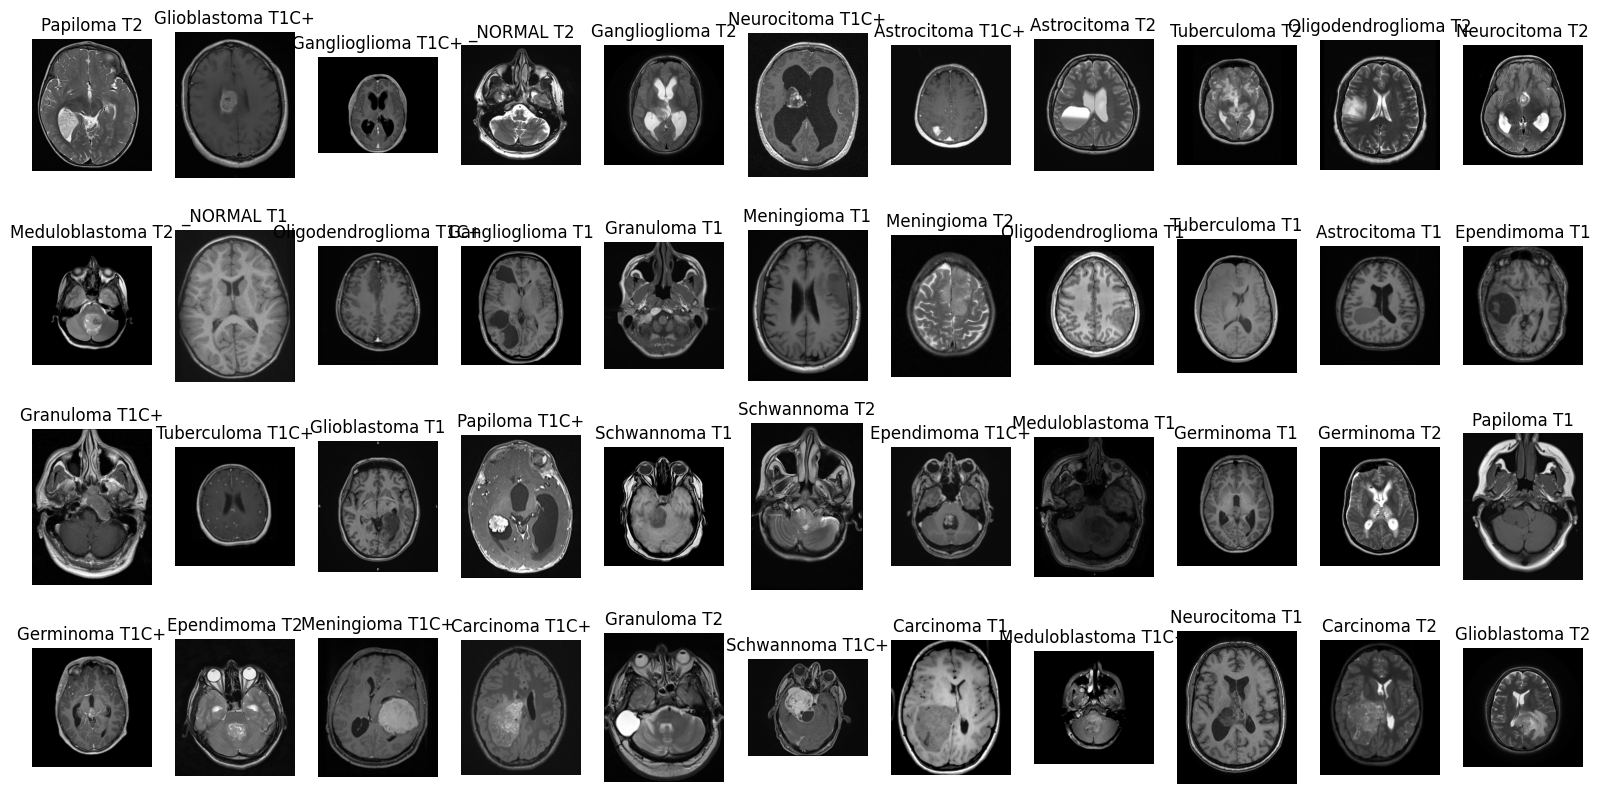

In [13]:
img_paths,label = img_path_load(os.path.join(Data_dir,"train"))
plt_show(img_paths,label,show_num)


In [14]:
works = os.cpu_count()
print(works)
batch_size = 32

2


In [15]:
# dataset 평균 표준편차 계산
def mean_std_dataset(train_ds):
  
  meanRGB = [np.mean(x.numpy(),axis=(1,2)) for x,_ in train_ds]
  stdRGB = [np.std(x.numpy(),axis=(1,2)) for x,_ in train_ds]

  meanR = np.mean([m[0] for m in meanRGB])
  meanG = np.mean([m[1] for m in meanRGB])
  meanB = np.mean([m[2] for m in meanRGB])

  stdR = np.std([s[0] for s in stdRGB])
  stdG = np.std([s[1] for s in stdRGB])
  stdB = np.std([s[2] for s in stdRGB])

  mean_ds = [meanR,meanG,meanB]
  std_ds = [stdR,stdG,stdB]

  print("mean : ",mean_ds)
  print("std : ",std_ds)

  return mean_ds,std_ds

def mean_std():
  default_transform = transforms.Compose([
    transforms.Resize(img_size),
    # 0~1 범위로 변환
    transforms.ToTensor()
    ])
  
  train_data = ImageFolder(os.path.join(Data_dir,"train"),default_transform)
  return mean_std_dataset(train_data)

In [16]:
mean,std = mean_std()

mean :  [0.18476693, 0.18476258, 0.18476264]
std :  [0.03752447, 0.03752488, 0.037524816]


In [17]:
# train data
def image_to_trainset(batch_size,val_size):
  start = time.time()

  transform = transforms.Compose([
      # image resize
      transforms.Resize(img_size),
      # 0~1 범위로 변환
      transforms.ToTensor(),
      # ( Input(channel) - mean(channel) ) / std(channel)
      transforms.Normalize(mean,std),
      transforms.RandomRotation(5)
  ])

  train_data = ImageFolder(os.path.join(Data_dir,"train"),transform)
  # train_data.transform = _transform

  train_num = len(train_data)
  indices = list(range(train_num))
  np.random.shuffle(indices)
  # train,validation 분리할 기준점
  split_idx = int(np.floor(val_size*train_num))
  
  train_idxs = indices[split_idx:]
  train_sampler = SubsetRandomSampler(train_idxs)
  # DataLoader
  train_loader = DataLoader(train_data,
                            batch_size = batch_size,
                            sampler = train_sampler,
                            num_workers = works)
  if val_size == 0:
    return train_data,train_loader
  
  val_idxs = indices[:split_idx]
  val_sampler = SubsetRandomSampler(val_idxs)
  val_loader = DataLoader(train_data,
                          batch_size = batch_size,
                          sampler = val_sampler,
                          num_workers = works)
  print(f"train_length : {len(train_data)-split_idx} val_length : {split_idx}")
  print(f"Processing Time : {time.time()-start:.2f}s")
  return train_data,train_loader,val_loader
# test data
def image_to_testset():
  transform = transforms.Compose([
      transforms.Resize(img_size),
      transforms.ToTensor(),
      transforms.Normalize(mean,std)
  ])
  test_data = ImageFolder(os.path.join(Data_dir,"test"),transform)
  classes = len(test_data.classes)
  test_loader = DataLoader(test_data,
                           batch_size=classes,
                           num_workers = works)
  
  return test_data,test_loader

In [18]:
train_data , train_loader, val_loader = image_to_trainset(batch_size,0.375)

test_data , test_loader = image_to_testset()

print()

train_length : 2228 val_length : 1336
Processing Time : 0.01s



In [19]:
num_classes = len(train_data.classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [20]:
class network(nn.Module):
  def __init__(self):
    super(network,self).__init__()
    self.pre_train = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    print("output : ",self.pre_train.classifier)
    input_features_fc_layer = self.pre_train.classifier[1].out_features

    self.fcl = nn.Sequential(
        nn.BatchNorm1d(input_features_fc_layer),
        nn.Linear(input_features_fc_layer,512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.BatchNorm1d(512),
        nn.Linear(512,num_classes)
    )
  
  def forward(self,x):
    x = self.pre_train(x)
    x = self.fcl(x)
    return x


In [21]:
# pre_trained
learning_rate = 1e-3
model = network().to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[10,15],gamma=0.5)

params = list(model.parameters())
print(params[-1])

output :  Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
Parameter containing:
tensor([ 6.4827e-05,  1.3912e-02,  2.9072e-03,  7.0471e-03,  5.1197e-03,
         3.9185e-03, -2.0406e-02,  2.3857e-02, -8.9481e-03,  4.8253e-03,
         2.6996e-02,  2.3782e-02,  4.2199e-02, -9.3647e-03, -1.8529e-02,
        -3.9964e-02, -3.2063e-02, -3.1242e-02, -1.7347e-02, -3.2125e-02,
        -1.8519e-02, -2.3802e-02, -2.9309e-02, -1.5148e-02,  3.0666e-02,
        -2.5758e-02,  4.2332e-02, -1.7037e-02,  2.4965e-02,  8.5715e-03,
         5.6028e-03, -3.1867e-02, -2.6831e-02,  8.4446e-03, -2.1393e-02,
         2.3361e-03,  3.6449e-02, -3.8138e-02,  3.7868e-02, -1.7125e-02,
        -3.1869e-03, -4.4055e-02, -1.1871e-02,  2.1251e-02], device='cuda:0',
       requires_grad=True)


In [22]:
train_size = len(train_loader.sampler)
val_size = len(val_loader.sampler)

In [23]:
def acc_count(predict,y):
  # 예상 y와 실제 y값 비교해 true값 count
  count = (predict.argmax(axis=1) == y).type(torch.float).sum().item()
  return count

# sec, ms 출력
def time_print(sec):
  print(f" - {sec:.0f}s {sec*1000%1000:.0f}ms/epoch")

def pg_bar(data_loader):
  return tqdm(data_loader,ncols=100)

In [24]:
def train(train_loader,val_loader,model,loss_fn,optimizer):
  start = time.time()

  batch_acc = 0
  batch_loss = 0
  data_size = 0

  train_bar = pg_bar(train_loader)
  for batch, (x, y) in enumerate(train_bar):
    x,y = x.to(device),y.to(device)
    it_size = len(x)
    predict = model(x)
    loss = loss_fn(predict, y)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # train_data의 batch 결과 저장
    batch_acc += acc_count(predict,y)
    batch_loss += loss.item() * it_size
    data_size += it_size

    train_acc = batch_acc/data_size
    train_loss = batch_loss/data_size

    train_bar.set_description(f"accuracy = {train_acc:.2%} - loss = {train_loss:.4f} ")
  
  scheduler.step()
  
  val_acc = 0
  with torch.no_grad():
    val_loss = 0
    for x,y in val_loader:
      x,y = x.to(device),y.to(device)
      predict = model(x)
      # validation_data의 batch loss
      val_loss += loss_fn(predict,y).item() * len(x)
      val_acc += acc_count(predict,y)
    
    # validation loss 평균
    val_loss /= val_size
    val_acc /= val_size
    print(f" - val_accuracy: {val_acc:.2%} - val_loss: {val_loss:>.4f}",end="")
  
  time_print(time.time()-start)
  return train_acc,train_loss,val_acc,val_loss

In [25]:
def test(dataloader,model,loss_fn,classes=""):
  size = len(dataloader.dataset)
  print("test size : ", size)

  model.eval()
  test_loss, test_acc = 0,0
  with torch.no_grad():
    for x,y in pg_bar(dataloader):
      x,y = x.to(device),y.to(device)
      predict = model(x)
      test_loss += loss_fn(predict, y).item() * len(x)
      test_acc += acc_count(predict,y)
    
  test_loss /= size
  test_acc /= size
  print(f"Test Error: \n Accuracy: {test_acc:>0.2%}, Avg loss: {test_loss:>4f} \n")


In [26]:
epochs = 25
metrics = ["train_acc","train_loss","val_acc","val_loss"]
hist = [[],[],[],[]]

In [27]:
for epoch in range(epochs):
  print(f"epoch : {epoch + 1}")
  train_acc,train_loss,val_acc,val_loss = train(train_loader,val_loader,model,loss,optimizer)
  hist[0].append(train_acc)
  hist[1].append(train_loss)
  hist[2].append(val_acc)
  hist[3].append(val_loss)
  

epoch : 1


accuracy = 40.22% - loss = 2.3924 : 100%|███████████████████████████| 70/70 [00:20<00:00,  3.43it/s]


 - val_accuracy: 52.92% - val_loss: 1.8372 - 29s 55ms/epoch
epoch : 2


accuracy = 63.15% - loss = 1.4067 : 100%|███████████████████████████| 70/70 [00:19<00:00,  3.63it/s]


 - val_accuracy: 59.96% - val_loss: 1.4962 - 28s 616ms/epoch
epoch : 3


accuracy = 69.93% - loss = 1.1004 : 100%|███████████████████████████| 70/70 [00:19<00:00,  3.55it/s]


 - val_accuracy: 64.97% - val_loss: 1.2562 - 29s 202ms/epoch
epoch : 4


accuracy = 74.73% - loss = 0.8905 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.86it/s]


 - val_accuracy: 69.24% - val_loss: 1.0886 - 28s 407ms/epoch
epoch : 5


accuracy = 79.71% - loss = 0.7336 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.86it/s]


 - val_accuracy: 70.96% - val_loss: 1.0814 - 28s 776ms/epoch
epoch : 6


accuracy = 81.06% - loss = 0.6440 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.77it/s]


 - val_accuracy: 73.28% - val_loss: 1.0027 - 27s 374ms/epoch
epoch : 7


accuracy = 84.87% - loss = 0.5547 : 100%|███████████████████████████| 70/70 [00:19<00:00,  3.61it/s]


 - val_accuracy: 78.07% - val_loss: 0.8724 - 28s 795ms/epoch
epoch : 8


accuracy = 88.02% - loss = 0.4185 : 100%|███████████████████████████| 70/70 [00:19<00:00,  3.60it/s]


 - val_accuracy: 79.12% - val_loss: 0.8256 - 29s 98ms/epoch
epoch : 9


accuracy = 90.80% - loss = 0.3309 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.88it/s]


 - val_accuracy: 81.14% - val_loss: 0.7057 - 28s 789ms/epoch
epoch : 10


accuracy = 93.22% - loss = 0.2406 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.85it/s]


 - val_accuracy: 81.44% - val_loss: 0.7068 - 28s 884ms/epoch
epoch : 11


accuracy = 96.10% - loss = 0.1310 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.84it/s]


 - val_accuracy: 87.57% - val_loss: 0.5031 - 28s 672ms/epoch
epoch : 12


accuracy = 98.56% - loss = 0.0637 : 100%|███████████████████████████| 70/70 [00:19<00:00,  3.63it/s]


 - val_accuracy: 88.62% - val_loss: 0.4462 - 28s 692ms/epoch
epoch : 13


accuracy = 98.88% - loss = 0.0498 : 100%|███████████████████████████| 70/70 [00:19<00:00,  3.61it/s]


 - val_accuracy: 88.47% - val_loss: 0.4440 - 29s 17ms/epoch
epoch : 14


accuracy = 99.55% - loss = 0.0318 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.82it/s]


 - val_accuracy: 89.90% - val_loss: 0.4363 - 28s 903ms/epoch
epoch : 15


accuracy = 99.33% - loss = 0.0302 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.80it/s]


 - val_accuracy: 90.19% - val_loss: 0.4444 - 28s 913ms/epoch
epoch : 16


accuracy = 99.69% - loss = 0.0241 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.77it/s]


 - val_accuracy: 90.79% - val_loss: 0.3972 - 28s 889ms/epoch
epoch : 17


accuracy = 99.73% - loss = 0.0205 : 100%|███████████████████████████| 70/70 [00:19<00:00,  3.55it/s]


 - val_accuracy: 90.34% - val_loss: 0.4225 - 28s 170ms/epoch
epoch : 18


accuracy = 99.64% - loss = 0.0192 : 100%|███████████████████████████| 70/70 [00:19<00:00,  3.61it/s]


 - val_accuracy: 91.02% - val_loss: 0.3683 - 29s 19ms/epoch
epoch : 19


accuracy = 99.91% - loss = 0.0116 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.81it/s]


 - val_accuracy: 91.24% - val_loss: 0.4007 - 28s 38ms/epoch
epoch : 20


accuracy = 99.78% - loss = 0.0117 : 100%|███████████████████████████| 70/70 [00:18<00:00,  3.81it/s]


 - val_accuracy: 92.59% - val_loss: 0.3671 - 28s 92ms/epoch


In [28]:
y_pred = test(test_loader,model,loss)

test size :  915


100%|███████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.42it/s]

Test Error: 
 Accuracy: 93.88%, Avg loss: 0.304866 



In [29]:
with torch.no_grad():
  print("test_data ", test_data[1])
  # 실제값
  y_test = np.array([i[1] for i in test_data])

  # 예측값
  y_pred = torch.cuda.FloatTensor([i[0].tolist() for i in test_data])
  y_pred = model(y_pred).argmax(dim=1).cpu().numpy()
  
print(classification_report(y_test,y_pred))

test_data  (tensor([[[-4.9239, -4.9239, -4.9239,  ..., -4.9239, -4.9239, -4.9239],
         [-4.9239, -4.9239, -4.9239,  ..., -4.9239, -4.9239, -4.9239],
         [-4.9239, -4.9239, -4.9239,  ..., -4.9239, -4.9239, -4.9239],
         ...,
         [-4.9239, -4.9239, -4.9239,  ..., -4.9239, -4.9239, -4.9239],
         [-4.9239, -4.9239, -4.9239,  ..., -4.9239, -4.9239, -4.9239],
         [-4.9239, -4.9239, -4.9239,  ..., -4.9239, -4.9239, -4.9239]],

        [[-4.9237, -4.9237, -4.9237,  ..., -4.9237, -4.9237, -4.9237],
         [-4.9237, -4.9237, -4.9237,  ..., -4.9237, -4.9237, -4.9237],
         [-4.9237, -4.9237, -4.9237,  ..., -4.9237, -4.9237, -4.9237],
         ...,
         [-4.9237, -4.9237, -4.9237,  ..., -4.9237, -4.9237, -4.9237],
         [-4.9237, -4.9237, -4.9237,  ..., -4.9237, -4.9237, -4.9237],
         [-4.9237, -4.9237, -4.9237,  ..., -4.9237, -4.9237, -4.9237]],

        [[-4.9237, -4.9237, -4.9237,  ..., -4.9237, -4.9237, -4.9237],
         [-4.9237, -4.9237, -4.92

In [30]:
torch.save(model.state_dict(),"model.pth")
print("save model")

save model


In [31]:
model = network()

model.load_state_dict(torch.load("model.pth"))
print("load model")

output :  Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
load model


In [32]:
def draw_plot(history,line_style=["-","-."],color=["blue","red"]):
  plt.figure(figsize=(6,4))
  for i in range(4):
    plt.plot(history[i],c=color[i%2],label=metrics[i],alpha=0.5,linestyle=line_style[i//2])
  plt.xlabel("Epochs")
  plt.legend()
  plt.show()

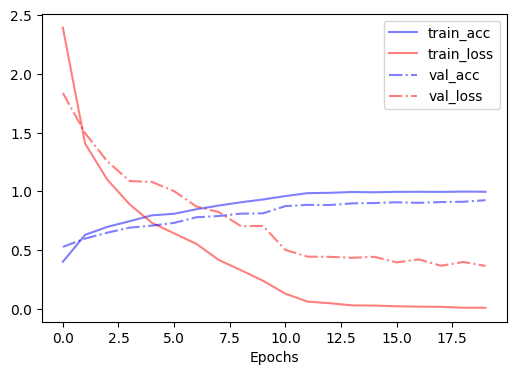

In [33]:
draw_plot(hist)